# RISM - A Gentle Introduction

We are going to write a Python implementation of the extended RISM equation with the goal of computing the direct, indirect and total correlation function along with the radial distribution function.

First, we import the libraries we will be needing:

In [1]:
import numpy as np
from scipy.fftpack import dstn, idstn
from scipy.special import erf
import matplotlib.pyplot as plt

First, we need to set up our problem domain. While the RISM equations are written as continuous functions $r$ (e.g. $c(r)$), computationally we solve them on a discretised grid.

We'll set up a discrete domain of length (or radius since we are working with spherically symmetric functions) $r = 15\, Å$ partitioned into $N = 100$ points. The resulting grid spacing is given by $\Delta r = \frac{r}{N}$.

In [2]:
r = 12.8
N = 128
dr = r / N

We also want to set up a grid spacing for our Fourier-space grid such that $\Delta r \Delta k = \frac{\pi}{N}$

In [3]:
dk = 2.0 * np.pi / (2.0 * N * dr)

Lets check the equality we stated above:

In [4]:
np.isclose(dr * dk, np.pi / N)

True

We use `np.isclose()` here because we are comparing floating point numbers. Using `==` would not work since there is always some precision loss with floats. You need to compared them within tolerances instead.

We can use these to generate our real and Fourier-space midpoint grids.

In [5]:
r_grid = np.arange(0.5, N, 1.0) * dr
k_grid = np.arange(0.5, N, 1.0) * dk

## Simple Argon Liquid

Now that we have our problem domain set up, we can focus on solving a particular problem. We're going to look at solving RISM for a simple Lennard-Jones Argon liquid system.

We first need to set up the thermodynamical state of the system and the unit systems we're going to use. We'll be working with energies in kJ / mol.

In [6]:
T = 300.0 # Kelvin
kB = 8.314462618e-3 # kJ / mol / K
beta = 1.0 / T / kB # Thermodynamic Beta

We also need to define the parameters and coordinates for Argon, as well as its number density. 

In [7]:
epsilon = 0.99773551416
sigma = 3.4
coords = np.array([0.0, 0.0, 0.0])
rho = 0.021017479720736955

We need to tabulate the LJ potential with the above parameters. We define a function to evaluate the potential over a grid, and then we plot the potential.

In [8]:
def LJ(epsilon, sigma, r):
    return 4.0 * epsilon * ( np.power( (sigma / r), 12) - np.power( (sigma / r), 6) )

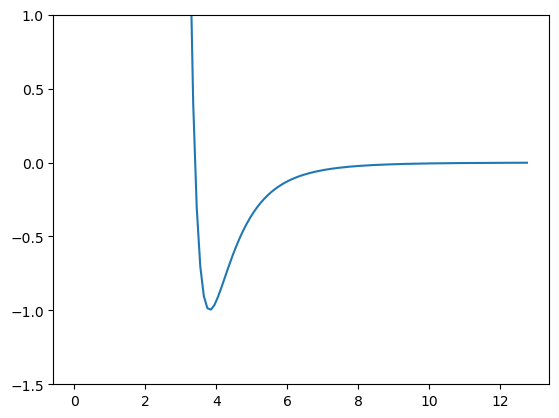

In [9]:
ur = LJ(epsilon, sigma, r_grid)

plt.plot(r_grid, ur)
plt.ylim([-1.5, 1.0])
plt.show()

One aspect of the RISM equation that we need to consider is the intramolecular correlation function $\omega(k)$. In the case of a simple liquid, $\omega(k) = 1$, in which case we the RISM equation reduces to the Ornstein-Zernike (OZ) equation.
We'll implement the full RISM equation, but we will set $\omega(k)$ to 1 for the case our current system.

In [10]:
wk = np.ones(N)

Another aspect is the closure. The closure is what relates our unknowns ($h(r)$ and $c(r)$), in a sense "closing" the RISM equation.
Generally the closure in terms of $c(r)$ is $$ c(r) = e^{-\beta u(r) + t(r) - B(r)} - t(r) - 1 $$ where $B(r)$ is the bridge function - something that we need to approximate - and $t(r) = h(r) - c(r)$ is the indirect correlation function.

We're going to use the simplest approximation, $B(r) = 0$. This is the Hypernetted Chain (HNC) closure.

$$ c(r) = e^{-\beta u(r) + t(r)} - t(r) - 1 $$

In [11]:
def HNC(beta, ur, tr):
    return np.exp(-beta * ur + tr) - 1.0 - tr

The final detail before we implement the RISM equation is that we need to be able to transform our correlation functions into Fourier-space and back.
We use the Fourier transforms of spherically symmetric functions:

$$ f(k) = 4 \pi \int_0^\infty f(r) r^2 \frac{\sin(kr)}{kr} dr $$

and the inverse:

$$ f(r) = \frac{1}{2 \pi^2} \int_0^\infty f(k) k^2 \frac{\sin(kr)}{kr} dk $$

The function $J_0(kr) = \frac{\sin(kr)}{kr}$ is the zeroth-order spherical Bessel function of the first kind, so sometimes these transforms are called Fourier-Bessel (or Hankel) transforms.

This can neatly be related to the Fourier sine transform:

$$ f(k) = \int_0^\infty f(r) \sin(kr) dr $$

$$ f(r) = \frac{2}{\pi} \int_0^\infty f(k) \sin(kr) dk $$

So that the fourier transform of the spherically symmetric function $f(r)$ is just the Fourier sine transform of the function $f(r) \cdot r$

Scipy has discrete sine transform functions we can use.

In [12]:
def fbt(fr, r, k, dr):
    return 2.0 * np.pi * dr * dstn(fr * r, type=4, axes=[0]) / k

def ifbt(fk, r, k, dk):
    return dk / 4.0 / np.pi / np.pi * idstn(fk * k, type=4, axes=[0]) / r

We have all the key parts to solve the RISM equation now.
The equation in Fourier-space is $$h(k) = \omega(k) * c(k) * \omega(k) - \rho * \omega(k) * c(k) * h(k)$$
We can rearrange this for $h(k)$ $$h(k) = [1 - \rho * \omega(k) * c(k)]^{-1} \omega(k) * c(k) * \omega(k)$$

For brevity, I'm going to drop the function argument $(k)$
$$h = [1 - \rho\omega c]^{-1} \omega c \omega$$

We're interested in calculating the indirect correlation function $t(k)$ $$t = [1 - \rho\omega c]^{-1} \omega c \omega - c$$

In [13]:
def RISM(cr, w, p, r, k, dr, dk):
    # Transform c(r) to c(k)
    ck = fbt(cr, r, k, dr)
    # Solve the RISM equation for t(k)
    tk = w * ck * w / (1.0 - p * w * ck) - ck
    # Transform t(k) to t(r)
    tr = ifbt(tk, r, k, dk)
    return tr

We have all the equations we need to perform a single closure and RISM calculation. Now we need to numerically solve this problem.

The RISM equation is an integro-differential equation, and is posed to be solved using fixed-point iteration (i.e. the self-consistent approach used in electronic structure theory e.g. for solving Hartree-Fock).

We set some initial guess for $t_0(r)$, and use that as input into the closure and RISM equation, and get a new value out. If we represent the closure and RISM equation as an operator $F(\cdot)$ on $t(r)$ then we get a value of $F(t(r))$.

We can then mix this new value with our initial value to obtain a new solution for $t(r)$ $$t_1(r) = \alpha F(t_0(r))  + (1 - \alpha) t_0(r) $$

More generally $$t_{k+1}(r) = \alpha F(t_k(r)) + (1 + \alpha) t_k(r)$$

where $\alpha$ is a dampening parameter. The lower this is, the stiffer our iteration process is (because we're including more of the previous solution than the current). This is called Picard iteration.


We keep iterating this set of equations and check the difference between current and previous solutions until that difference is below some tolerance $\zeta$ $$ |t_{k+1}(r) - t_{k}(r)| < \zeta $$

Once the difference is below this tolerance, the calculation is finished.

We use an initial guess of $t(r) = 0$ and a tolerance of $\zeta = 1\times10^{-8}$

In [17]:
# Setting up parameters for iterations
tolerance = 1e-8
max_steps = 1000
step = 0

# 1.0 is essentially undamped direct iteration
alpha = 1.0

# Setting up initial guess
tr = np.zeros(N)

while step < max_steps:
    # Store previous t(r)
    tr_prev = tr

    # t(r) -> c(r) from closure
    cr = HNC(beta, ur, tr)

    # c(r) -> F(t(r)) from RISM equation
    f_tr = RISM(cr, wk, rho, r_grid, k_grid, dr, dk)

    # Use Picard iteration to get the new solution
    # Since we set alpha = 1.0 above, this is 
    # essentially direct iteration (tr_new = f_tr).
    tr_new = alpha * f_tr + (1.0 - alpha) * tr_prev
    
    # Check the absolute value of the difference between the current and previous solution
    # We use .max() because we want to check that all values are below the tolerance, and
    # if the maximum value of the difference array is below, then so must the other values be.
    diff = abs((tr_new - tr_prev).max())
    
    # Set t(r) to the new t(r) we just computed
    tr = tr_new

    # Print the iteration step and difference
    print("Iteration: {step} Diff: {diff}".format(step=step, diff=diff))

    # Test if the difference is below our tolerance
    if diff < tolerance:
        break

    # Update our step counter. We have a max_step because we don't want this calculation to go 
    # on forever and freeze our PC.
    step += 1

Iteration: 0 Diff: 2.646485854504701
Iteration: 1 Diff: 0.5115996830003565
Iteration: 2 Diff: 0.9085989627278668
Iteration: 3 Diff: 0.8244046172839896
Iteration: 4 Diff: 0.6318833697188797
Iteration: 5 Diff: 0.6267691545658298
Iteration: 6 Diff: 0.5584309452299197
Iteration: 7 Diff: 0.5030111773625068
Iteration: 8 Diff: 0.4694149289689209
Iteration: 9 Diff: 0.4296154675088175
Iteration: 10 Diff: 0.3965091480370351
Iteration: 11 Diff: 0.3684440866100349
Iteration: 12 Diff: 0.34138886112290123
Iteration: 13 Diff: 0.3174885702383783
Iteration: 14 Diff: 0.2959089391774672
Iteration: 15 Diff: 0.275861368637889
Iteration: 16 Diff: 0.2576362680275839
Iteration: 17 Diff: 0.24089707693739904
Iteration: 18 Diff: 0.2254021807903186
Iteration: 19 Diff: 0.21112770054160634
Iteration: 20 Diff: 0.19791630841355357
Iteration: 21 Diff: 0.18565265373471185
Iteration: 22 Diff: 0.17427411453888553
Iteration: 23 Diff: 0.1636918796349267
Iteration: 24 Diff: 0.1538346845829821
Iteration: 25 Diff: 0.144647765

Once solved, we can use the calculated correlation functions to calculate the radial distribution function and plot it.

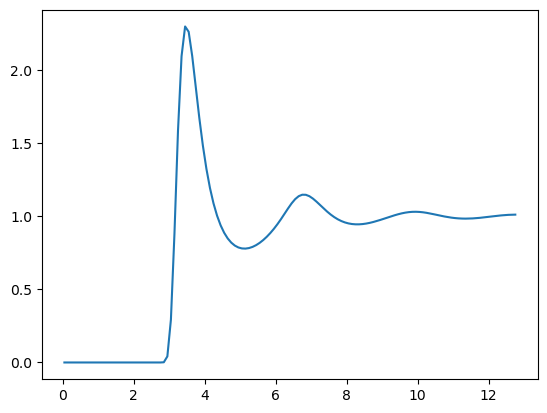

In [15]:
# Get c(r) from the solved t(r)
cr = HNC(beta, ur, tr)

# Get h(r)
hr = tr + cr

# Get and plot g(r)
gr = hr + 1

plt.plot(r_grid, gr)
plt.show()

This is the radial distribution function for a Lennard-Jones Argon liquid!

On your machine you might find that it took over 300 iterations to come to a solution.
We're using a very simple iteration scheme, but there are more complex iteration schemes we can use that can reduce the number of iterations.
We will look at one convergence acceleration method later, but most methods are beyond the scope of this tutorial.

## Nitrogen - Introducing the Coulomb Potential